In [1]:
#coding: utf-8
import numpy as np
import pandas as pd
import re
import jieba
import os
import time
import random
import jieba 
import sklearn 
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import time
import gensim
import jieba.analyse
import time

In [2]:
from gensim.models import CoherenceModel
from gensim import models
def tw_lda_get_tfidf(text,gamma=1.0):
    #1.用正文+标题作为dictionary，过滤极端值
    content_and_title=[i.split(" ") for i in text["微博正文(无标题切词后)"]]
    dictionary = gensim.corpora.Dictionary(content_and_title)
    dictionary.filter_extremes(no_below=15,no_above=0.8, keep_n=100000)
    
    #2.计算标题的tfidf
    processed_docs_title=[i.split(" ") for i in text["标题(切词后)"]]
    bow_corpus_title = [dictionary.doc2bow(doc) for doc in processed_docs_title]
    tfidf_title = models.TfidfModel(bow_corpus_title,normalize=False)
    corpus_tfidf_title = tfidf_title[bow_corpus_title]
#     print("corpus_tfidf_title",corpus_tfidf_title)
    
    #3.计算正文+标题的tfidf
    processed_docs_content=[i.split(" ") for i in text["微博正文(无标题切词后)"]]
    bow_corpus_content = [dictionary.doc2bow(doc) for doc in processed_docs_content]
    tfidf_content = models.TfidfModel(bow_corpus_content,normalize=False)
    corpus_tfidf_content = tfidf_content[bow_corpus_content]
#     print("corpus_tfidf_content",corpus_tfidf_content)
    
    #4.把标题和正文tfidf结合在一起
    new_tfidf=[]
    for i in range(len(corpus_tfidf_content)):#corpus_tfidf2[i]
        dict_2={one:two for one,two in corpus_tfidf_content[i]}
        dict_1={one:two for one,two in corpus_tfidf_title[i]}
        for j in dict_1.keys():
            if j in dict_2.keys():
                dict_2[j]=(1-gamma)*dict_2[j]+gamma*dict_1[j]
        new_tfidf_part=[(one,two) for one,two in sorted(dict_2.items(), key=lambda d: d[0],reverse=False)]
#         print("new_tfidf_part",new_tfidf_part)
#        new_tfidf.append(new_tfidf_part)
#        normed=gensim.models.tfidfmodel.smartirs_normalize(new_tfidf_part,"c") 
#        new_tfidf.append(normed)
        new_tfidf.append(new_tfidf_part)
    
    #5.返回tfidf
    return new_tfidf,dictionary


# lda的模型
from gensim.models import CoherenceModel
from gensim import models

def lda_and_coherence_score(processed_docs,num_topics,methods,corpus_tfidf_tw_lda=False,dictionary_tw_lda=False):
    
    if methods=="tw_lda":
        dictionary=dictionary_tw_lda
        corpus=corpus_tfidf_tw_lda
    else:
        dictionary = gensim.corpora.Dictionary(processed_docs)
        dictionary.filter_extremes(no_below=15, no_above=0.8, keep_n=100000)
        bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
        if methods=="lda_normal":
            corpus=bow_corpus
        elif methods=="lda_tfidf":
            tfidf = models.TfidfModel(bow_corpus,normalize=False) 
            corpus_tfidf = tfidf[bow_corpus]
            corpus=corpus_tfidf
    model = gensim.models.LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary,
                                       passes=20,iterations=5000
                                       #,eval_every=1
                                      )
    coherence = CoherenceModel(model=model, texts=processed_docs,dictionary=dictionary, coherence='c_v')
    score = coherence.get_coherence()
    logper=model.log_perplexity(corpus)
    return model,score,logper


def cs_bar_5(c,num_topics,methods,corpus_tfidf_tw_lda=False,dictionary_tw_lda=False):
    cs_list=[]
    logper_list=[]
    if methods=="tw_lda":
        for i in range(5):
            lda,cs,logper=lda_and_coherence_score(c,num_topics,methods,corpus_tfidf_tw_lda=corpus_tfidf_tw_lda,dictionary_tw_lda=dictionary_tw_lda)
            cs_list.append(cs)
            logper_list.append(logper)
    else:
        for i in range(5):
            lda,cs,logper=lda_and_coherence_score(c,num_topics,methods)
            cs_list.append(cs)
            logper_list.append(logper)
#     cs_bar_5=sum(cs_list)/(len(cs_list)*1.0)          
#     logper_bar_5=sum(logper_list)/(len(logper_list)*1.0)  
    return lda,cs_list,logper_list                          

In [3]:
text=pd.read_csv("./huanqiu_news_with_title_2.csv")
drop_na=[]
for i in range(text.shape[0]):
    if pd.isnull(text.loc[i]).any():
        drop_na.append(i)

text=text.drop(drop_na)
text=text.reset_index(drop=True)

text.head()

,发布时间,微博正文,标题,微博正文（去掉标题）,微博正文(无标题切词后),标题(切词后),微博正文(有标题切词后)
0,2019-12-31 23:50,【如何获得稳定的8小时睡眠？】如今随着新的信息技术的发展，比如笔记本电脑，手机，游戏成了影响...,【如何获得稳定的8小时睡眠？】,如今随着新的信息技术的发展，比如笔记本电脑，手机，游戏成了影响着人们的睡眠时间的主要原因，7...,获得 稳定 小时 睡眠 信息技术 发展 笔记本电脑 手机 游戏 影响 人们 睡眠 主要 原因...,获得 稳定 小时 睡眠,获得 稳定 小时 睡眠 获得 稳定 小时 睡眠 信息技术 发展 笔记本电脑 手机 游戏 影响...
1,2019-12-31 23:30,【这妈妈不太省心！怕被抓拍#女子拿孩子的画遮号牌#】近日，四川自贡市一女子违停在路边，由于担...,【这妈妈不太省心！怕被抓拍#女子拿孩子的画遮号牌#】,近日，四川自贡市一女子违停在路边，由于担心被监控抓拍，竟用孩子的画遮挡号牌。孩子制止其母无果...,妈妈 不太 省心 抓拍 孩子 号牌 自贡市 违停 路边 担心 监控 抓拍 孩子 遮挡 号牌 ...,妈妈 省心 抓拍 孩子 号牌,妈妈 省心 抓拍 孩子 号牌 妈妈 不太 省心 抓拍 孩子 号牌 自贡市 违停 路边 担心 ...
2,2019-12-31 23:10,【#致敬2019那些温暖瞬间#，愿2020更美好】回顾2019年，发生在齐鲁大地上，值得记忆...,【#致敬2019那些温暖瞬间#，愿2020更美好】,回顾2019年，发生在齐鲁大地上，值得记忆的暖心瞬间：10岁男孩2月增重12斤捐造干救父；夫...,致敬 温暖 瞬间 美好 回顾 齐鲁大地 值得 记忆 瞬间 男孩 增重 捐造 干救父 夫妻 雾...,致敬 温暖 瞬间 美好,致敬 温暖 瞬间 美好 致敬 温暖 瞬间 美好 回顾 齐鲁大地 值得 记忆 瞬间 男孩 增重...
3,2019-12-31 22:50,【浪漫！#85岁爷爷敬老院娶82岁奶奶#：上海话“搭讪”，开音乐会庆祝】 陕西西安一敬老院，...,【浪漫！#85岁爷爷敬老院娶82岁奶奶#：上海话“搭讪”，开音乐会庆祝】,陕西西安一敬老院，85岁的陈爷爷迎娶82岁的沈奶奶。沈奶奶爱在大厅里弹钢琴，陈爷爷常坐在后...,浪漫 爷爷 敬老院 奶奶 上海 搭讪 音乐会 庆祝 陕西 西安 敬老院 爷爷 迎娶 奶奶 奶...,浪漫 爷爷 敬老 敬老院 奶奶 上海 搭讪 音乐 音乐会 会庆 庆祝,浪漫 爷爷 敬老 敬老院 奶奶 上海 搭讪 音乐 音乐会 会庆 庆祝 浪漫 爷爷 敬老院 奶...
4,2019-12-31 22:30,【瑞典环保少女：不想和特朗普说话，不想浪费时间】12月30日，瑞典环保少女通贝里接受BBC《...,【瑞典环保少女：不想和特朗普说话，不想浪费时间】,12月30日，瑞典环保少女通贝里接受BBC《今日》电台采访时，被问到如果有机会跟特朗普面对面...,瑞典 环保 少女 不想 特朗普 说话 不想 浪费时间 瑞典 环保 少女 贝里 接受 今日 电...,瑞典 环保 少女 不想 特朗普 说话 不想 浪费 浪费时间 费时 费时间,瑞典 环保 少女 不想 特朗普 说话 不想 浪费 浪费时间 费时 费时间 瑞典 环保 少女 ...


# xLDA & tfidf-LDA

In [4]:
start_ba=time.process_time()
topic_num=range(10,160,10)
c=[i.split(" ") for i in text["微博正文(有标题切词后)"]]

In [5]:
cs_nor={}
cs_nor_bar=[]

logper_nor={}
logper_nor_bar=[]

cs_tf={}
cs_tf_bar=[]

logper_tf={}
logper_tf_bar=[]



for i in topic_num:
    starti=time.process_time()
    num_topics=i
    print("i",i)
    
    lda1,cs1,logper1=cs_bar_5(c,num_topics,"lda_normal")
    
    cs_nor[i]=cs1
    cs_nor_bar1=sum(cs1)/(len(cs1)*1.0) 
    cs_nor_bar.append(cs_nor_bar1)
    
    logper_nor[i]=logper1
    logper_bar1=sum(logper1)/(len(logper1)*1.0)
    logper_nor_bar.append(logper_bar1)
    
    
    print("cs_nor",cs1)
    print("cs_nor_bar1",cs_nor_bar1)
    print("logper_nor",logper1)
    print("logper_bar1",logper_bar1)
    
    
    lda2,cs2,logper2=cs_bar_5(c,num_topics,"lda_tfidf")
    
    cs_tf[i]=cs2
    cs_tf_bar2=sum(cs2)/(len(cs2)*1.0) 
    cs_tf_bar.append(cs_tf_bar2)
    
    logper_tf[i]=logper2
    logper_bar2=sum(logper2)/(len(logper2)*1.0)
    logper_tf_bar.append(logper_bar2)
    
    
    print("cs_tf",cs2)
    print("cs_tf_bar2",cs_tf_bar2)
    print("logper_tf",logper2)
    print("logper_bar2",logper_bar2)
    
    endi=time.process_time()
    print('different for topic_num i:',i,'is',endi - starti)
    print("----------------------------------")

    
end_ba = time.process_time()
print('different is %6.3f' % (end_ba - start_ba))

i 10
cs_nor [0.48605991600224374, 0.4849070343480286, 0.47146662160793096, 0.4807457210502356, 0.46105786293175877]
cs_nor_bar1 0.47684743118803957
logper_nor [-7.688566278014729, -7.689186333762717, -7.699718369682393, -7.655556483579532, -7.698114850788782]
logper_bar1 -7.686228463165631
cs_tf [0.47304783292892216, 0.42206042642950353, 0.44637562763661415, 0.42486612501672827, 0.4336413195431489]
cs_tf_bar2 0.43999826631098343
logper_tf [-7.629020011612921, -7.675520206935687, -7.650398758418878, -7.655472789303183, -7.649878716182273]
logper_bar2 -7.652058096490589
different for topic_num i: 10 is 1907.875
----------------------------------
i 20
cs_nor [0.45063273208135657, 0.4408040622562802, 0.4431363821688847, 0.4588639681440953, 0.4834904393453221]
cs_nor_bar1 0.45538551679918776
logper_nor [-7.605905716581577, -7.629988766731369, -7.612014646554732, -7.618213386887834, -7.58999283989741]
logper_bar1 -7.611223071330585
cs_tf [0.43453946919203323, 0.4415356232036369, 0.4618724171

cs_nor [0.5145309045517611, 0.5153041855618242, 0.5177760636717581, 0.5085260991375664, 0.5005054546946697]
cs_nor_bar1 0.5113285415235159
logper_nor [-7.671230789272986, -7.66431582981601, -7.669423587633269, -7.679538717645501, -7.660544519027919]
logper_bar1 -7.669010688679137
cs_tf [0.539442724202979, 0.5325016763199286, 0.5329349973140468, 0.5319914655971045, 0.524535427948301]
cs_tf_bar2 0.532281258276472
logper_tf [-6.586976735765453, -6.587154447416736, -6.5920688340544205, -6.596609132030337, -6.589434177064523]
logper_bar2 -6.590448665266294
different for topic_num i: 140 is 3589.5
----------------------------------
i 150
cs_nor [0.5086025389005586, 0.5085346195780066, 0.5124441922782903, 0.5168109187572626, 0.5102494297347692]
cs_nor_bar1 0.5113283398497774
logper_nor [-7.68639089658045, -7.6854614639097285, -7.693309174822046, -7.698832779358461, -7.688565303466027]
logper_bar1 -7.6905119236273425
cs_tf [0.530786942559126, 0.5254919383283081, 0.5280344256051936, 0.529825240

In [6]:
print("cs_nor")
print(cs_nor)
print("----------------")
print("logper_nor")
print(logper_nor)
print("----------------")
print("cs_tf")
print(cs_tf)
print("----------------")
print("logper_tf")
print(logper_tf)
print("----------------")

cs_nor
{10: [0.48605991600224374, 0.4849070343480286, 0.47146662160793096, 0.4807457210502356, 0.46105786293175877], 20: [0.45063273208135657, 0.4408040622562802, 0.4431363821688847, 0.4588639681440953, 0.4834904393453221], 30: [0.4739921188200726, 0.4860781732311426, 0.4665201048082199, 0.45186876115333874, 0.45331390373381647], 40: [0.4648717959797053, 0.46882013081271373, 0.4758685965957449, 0.49616090762185616, 0.4665171381632369], 50: [0.49886103672228793, 0.4765146130096013, 0.493220582439, 0.48947472451623036, 0.4718024779950803], 60: [0.47392407482157783, 0.48237739972284754, 0.49541415808558936, 0.48243113314703545, 0.4897461409967965], 70: [0.4916048403458297, 0.48636302083440086, 0.4775524121609085, 0.49614446014346897, 0.4823735709101641], 80: [0.49000481175763844, 0.499541044373474, 0.4941645975725895, 0.4768290891463748, 0.5018684215430886], 90: [0.49519547346718623, 0.5008873011433292, 0.49316413526550373, 0.5007708578895891, 0.5024919029110435], 100: [0.5052811706162995

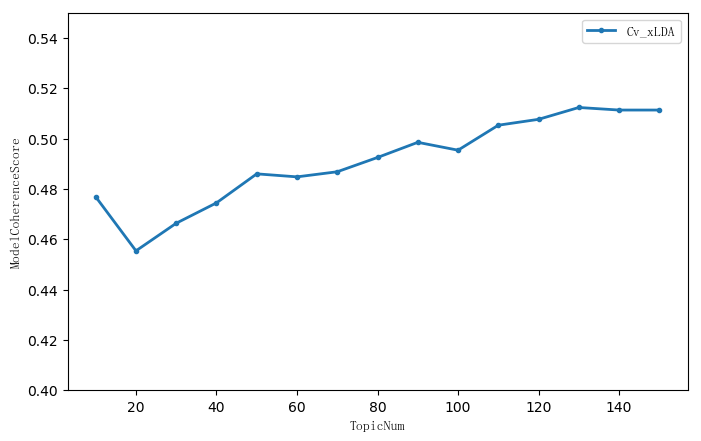

In [17]:
from matplotlib import font_manager
my_font = font_manager.FontProperties(fname='C:/Windows/Fonts/simfang.ttf')

plt.figure(figsize=(8,5),dpi=100)
plt.plot(topic_num,cs_nor_bar,label="Cv_xLDA",marker=".",linewidth=2)
#plt.plot(topic_num,cs_tf_bar,label="Cv_tfidfLDA",marker=".",linewidth=2)
# plt.plot(topic_num,cs_tw_bar,label="cs_tw",marker=".",linewidth=2)

#new_ticks = np.linspace(3, 25, 23)
#plt.xticks(new_ticks)
plt.ylim(0.4, 0.55)

plt.xlabel('TopicNum', fontproperties=my_font)
plt.ylabel('ModelCoherenceScore', fontproperties=my_font)

plt.legend(prop=my_font)

In [9]:
per_nor_bar=[]
for i in topic_num:
    per_nor_per=[2**((-1)*j) for j in logper_nor[i]]
    temp_per_nor_per=sum(per_nor_per)/(len(per_nor_per)*1.0) 
    per_nor_bar.append(temp_per_nor_per)

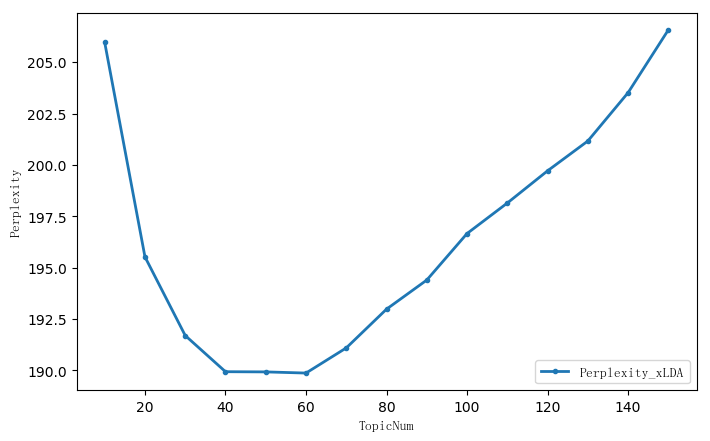

In [14]:
from matplotlib import font_manager
my_font = font_manager.FontProperties(fname='C:/Windows/Fonts/simfang.ttf')

plt.figure(figsize=(8,5),dpi=100)
plt.plot(topic_num,per_nor_bar,label="Perplexity_xLDA",marker=".",linewidth=2)
#plt.plot(topic_num,per_bar_tf,label="Perplexity_tfidfLDA",marker=".",linewidth=2)
# plt.plot(topic_num,cs_tw,label="cs_tw",marker=".",linewidth=2)

#new_ticks = np.linspace(3, 25, 23)
#plt.xticks(new_ticks)
#plt.ylim(0.0, 1.0)

plt.xlabel('TopicNum', fontproperties=my_font)
plt.ylabel('Perplexity', fontproperties=my_font)

plt.legend(prop=my_font)

In [27]:
tn=50 
c=[i.split(" ") for i in text["微博正文(无标题切词后)"]]

In [28]:
start_gamma_1=time.process_time()
gamma_l=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
cs_tw_dic={}
cs_tw_bar=[]
logper_tw_dic={}
logper_tw_bar=[]

for gamma in gamma_l:
    start_gamma=time.process_time()
    print("gamma",gamma)
    a,b=tw_lda_get_tfidf(text,gamma=gamma)

    i=tn
    num_topics=i
    print("num_topics is:",i)
        
    lda3,cs3,logper3=cs_bar_5(c,num_topics,"tw_lda",corpus_tfidf_tw_lda=a,dictionary_tw_lda=b)
        
    cs_tw_dic[gamma]=cs3
    cs3_bar=sum(cs3)/(len(cs3)*1.0)
    cs_tw_bar.append(cs3_bar)
    print("cs_tw_list",cs3)
    print("cs3_bar",cs3_bar)

    logper_tw_dic[gamma]=logper3
    logper3_bar=sum(logper3)/(len(logper3)*1.0)
    logper_tw_bar.append(logper3_bar)
    print("logper3",logper3)
    print("logper3_bar",logper3_bar)

    end_gamma=time.process_time()
    print('different for gamma:',gamma,'is',end_gamma-start_gamma)
    print("------------------")
        
end_gamma_1=time.process_time()
print('different for gamma(all):',gamma,'is',end_gamma_1-start_gamma_1)

gamma 0.0
num_topics is: 50
cs_tw_list [0.5140116150927553, 0.508045332515144, 0.4795185220352478, 0.5359287640479181, 0.4840683903696979]
cs3_bar 0.5043145248121527
logper3 [-7.04993538642238, -7.08232412953903, -7.080041461155349, -7.039266607725484, -7.071467720972509]
logper3_bar -7.06460706116295
different for gamma: 0.0 is 1647.53125
------------------
gamma 0.1
num_topics is: 50
cs_tw_list [0.4856957067250802, 0.494530834432821, 0.5086201527252147, 0.5000839047504548, 0.526459544272427]
cs3_bar 0.5030780285811995
logper3 [-7.076093851879675, -7.087700765087055, -7.1021177144866146, -7.084166406949677, -7.060459525355747]
logper3_bar -7.082107652751754
different for gamma: 0.1 is 1451.15625
------------------
gamma 0.2
num_topics is: 50
cs_tw_list [0.4871368261250516, 0.5041256131574664, 0.49240884438103494, 0.5004074491989621, 0.5205712381214881]
cs3_bar 0.5009299941968006
logper3 [-7.095774149510459, -7.090751142967519, -7.107607448573179, -7.07898083360304, -7.086260725701065]

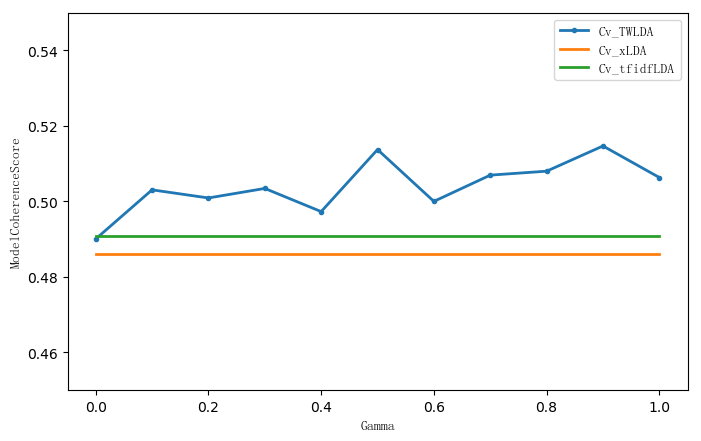

In [237]:
#画topicnum=50时，xLDA和tfidfLDA的Cv（这两个是定值，因此是水平的），不同gamma下TWLDA的大小
plt.figure(figsize=(8,5),dpi=100)

#cs_tw_bar[0]=0.4900683903696979

plt.plot(list(cs_tw_dic.keys()),cs_tw_bar,label="Cv_TWLDA",marker=".",linewidth=2)
# for m,n in zip(list(cs_tw_dic.keys()),cs_tw_bar):
#     plt.text(m+0.04, n+0.0015, round(n,5), ha='right', va= 'bottom',fontsize=8)

plt.plot(list(cs_tw_dic.keys()),[cs_nor_bar[4] for i in range(11)],label="Cv_xLDA",linewidth=2)
m=gamma_l[0]
n=cs_tw_bar[4]
# plt.text(m+0.04, n-0.005, round(n,5), ha='right', va= 'bottom',fontsize=8)


plt.plot(list(cs_tw_dic.keys()),[cs_tf_bar[4] for i in range(11)],label="Cv_tfidfLDA",linewidth=2)
m=gamma_l[0]
n=cs_tf_bar[4]
# plt.text(m+0.04, n-0.005, round(n,5), ha='right', va= 'bottom',fontsize=8)



plt.ylim(0.45,0.55)
plt.xlabel('Gamma', fontproperties=my_font)
plt.ylabel('ModelCoherenceScore', fontproperties=my_font)



plt.legend(prop=my_font)